<a href="https://colab.research.google.com/github/hanjidani/FL/blob/main/FedHetTest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
import numpy as np

# Define the three-layer CNN model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5)
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.max_pool2d(x, 2)
        x = torch.relu(self.conv2(x))
        x = torch.max_pool2d(x, 2)
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
def train_local_model(model, dataloader, epochs, lr):
    model.to(device)  # Move model to GPU
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr)
    model.train()
    training_loss = 0.0
    num_batches = len(dataloader)

    for epoch in range(epochs):
        epoch_loss = 0.0
        for data, target in dataloader:
            data, target = data.to(device), target.to(device)  # Move data to GPU
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        training_loss += epoch_loss / num_batches

    return model.state_dict(), training_loss / epochs

def evaluate_model(model, test_loader):
    model.to(device)  # Move model to GPU
    model.eval()
    test_loss = 0.0
    correct = 0
    num_batches = len(test_loader)
    criterion = nn.CrossEntropyLoss()

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)  # Move data to GPU
            output = model(data)
            loss = criterion(output, target)
            test_loss += loss.item()
            _, predicted = torch.max(output.data, 1)
            correct += (predicted == target).sum().item()

    accuracy = 100 * correct / len(test_loader.dataset)
    avg_test_loss = test_loss / num_batches
    return accuracy, avg_test_loss


In [ ]:
def train_fedavg(global_model, data_loaders, test_loader, epochs, lr, rounds):
    num_clients = len(data_loaders)
    train_losses = []

    for round in range(rounds):
        local_models = []

        # Distribute the global model to all clients and train locally
        for i in range(num_clients):
            local_model = SimpleCNN().to(device)  # Move local model to GPU
            local_model.load_state_dict(global_model.state_dict())
            local_state_dict, train_loss = train_local_model(local_model, data_loaders[i], epochs, lr)
            local_models.append(local_state_dict)
            train_losses.append(train_loss)

        # Aggregate local models
        global_state_dict = global_model.state_dict()
        for key in global_state_dict.keys():
            # Initialize an empty tensor to accumulate the values
            global_state_dict[key] = torch.zeros_like(global_state_dict[key]).to(device)  # Ensure tensor is on the correct device

            for local_model in local_models:
                # Ensure each local model's parameters are on the correct device
                global_state_dict[key] += local_model[key].to(device)

            global_state_dict[key] /= num_clients

        global_model.load_state_dict(global_state_dict)

        # Evaluate the global model on the test set
        accuracy, test_loss = evaluate_model(global_model, test_loader)
        avg_train_loss = sum(train_losses) / len(train_losses)
        generalization_error = test_loss - avg_train_loss
        print(f"Round {round + 1}/{rounds} - FedAvg Accuracy: {accuracy:.2f}%, Loss: {test_loss:.4f}, Generalization Error: {generalization_error:.4f}")

    return global_model, avg_train_loss


In [ ]:
def scaffold(global_model, data_loaders, test_loader, epochs, lr, rounds):
    num_clients = len(data_loaders)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Initialize global control variates on the correct device
    global_control_variates = [torch.zeros_like(param).to(device) for param in global_model.parameters()]

    for round in range(rounds):
        local_models = []
        local_control_variates = []
        train_losses = []

        for i in range(num_clients):
            local_model = SimpleCNN().to(device)
            local_model.load_state_dict(global_model.state_dict())
            local_cv = [torch.zeros_like(param).to(device) for param in local_model.parameters()]

            local_state_dict, train_loss = train_local_model(local_model, data_loaders[i], epochs, lr)
            local_models.append(local_state_dict)
            local_control_variates.append(local_cv)
            train_losses.append(train_loss)

        # Aggregate local models into the global model
        global_state_dict = global_model.state_dict()
        for key in global_state_dict.keys():
            global_state_dict[key] = torch.stack([local_model[key].to(device) for local_model in local_models]).mean(dim=0)

        global_model.load_state_dict(global_state_dict)

        # Update global control variates
        with torch.no_grad():
            for i, (global_cv, param) in enumerate(zip(global_control_variates, global_model.parameters())):
                param = param.to(device)
                global_cv = global_cv.to(device)

                if param.grad is None:
                    param.grad = torch.zeros_like(param).to(device)  # Handle None gradients

                update_term = torch.mean(torch.stack([
                    local_cv[i].to(device) + param.grad - global_cv
                    for local_cv in local_control_variates
                ]), dim=0)

                if update_term.shape == global_cv.shape:
                    global_cv += update_term

        # Evaluate the global model on the test set
        accuracy, test_loss = evaluate_model(global_model, test_loader)
        avg_train_loss = sum(train_losses) / len(train_losses)
        generalization_error = test_loss - avg_train_loss
        print(f"Round {round + 1}/{rounds} - SCAFFOLD Accuracy: {accuracy:.2f}%, Loss: {test_loss:.4f}, Generalization Error: {generalization_error:.4f}")

    return global_model, avg_train_loss  # Return the global model, not a tuple

In [ ]:
def create_datasets(heterogeneity_level, num_clients=10):
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
    full_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

    client_datasets = []
    labels = np.array(full_dataset.targets)
    indices = np.arange(len(full_dataset))

    # Determine the number of IID and non-IID samples per client
    total_samples = len(full_dataset) // num_clients
    non_iid_samples = int(heterogeneity_level * total_samples)
    iid_samples = total_samples - non_iid_samples

    for i in range(num_clients):
        # Create non-IID data for the client
        chosen_labels = np.random.choice(10, 2, replace=False)
        non_iid_indices = np.where((labels == chosen_labels[0]) | (labels == chosen_labels[1]))[0]
        non_iid_indices = np.random.choice(non_iid_indices, non_iid_samples, replace=False)

        # Create IID data for the client
        remaining_indices = np.setdiff1d(indices, non_iid_indices)
        iid_indices = np.random.choice(remaining_indices, iid_samples, replace=False)

        # Combine IID and non-IID data
        client_indices = np.concatenate([non_iid_indices, iid_indices])
        client_datasets.append(Subset(full_dataset, client_indices))

    return client_datasets


Running experiment for heterogeneity level: 0
Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:11<00:00, 887233.39it/s] 


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 125700.90it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:01<00:00, 1045256.32it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 2863879.85it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Round 1/5 - FedAvg Accuracy: 41.35%, Loss: 1.6366, Generalization Error: 0.9544
Round 2/5 - FedAvg Accuracy: 48.46%, Loss: 1.2945, Generalization Error: 0.8785
Round 3/5 - FedAvg Accuracy: 55.19%, Loss: 1.1211, Generalization Error: 0.8111
Round 4/5 - FedAvg Accuracy: 54.34%, Loss: 1.0951, Generalization Error: 0.8438
Round 5/5 - FedAvg Accuracy: 64.76%, Loss: 0.9094, Generalization Error: 0.6961
Round 1/5 - SCAFFOLD Accuracy: 67.72%, Loss: 1.0044, Generalization Error: 0.2673
Round 2/5 - SCAFFOLD Accuracy: 74.84%, Loss: 0.7279, Generalization Error: 0.5796
Round 3/5 - SCAFFOLD Accuracy: 81.56%, Loss: 0.5921, Generalization Error: 0.4969
Round 4/5 - SCAFFOLD Accuracy: 84.98%, Loss: 0.5219, Generalization Error: 0.4496
Round 5/5 - SCAFFOLD Accuracy: 84.53%, Loss: 0.5048, Generalization Error: 0.4459
Running experiment for heterogeneity level: 0.2
Round 1/5 - FedAvg Accuracy: 64.45%, Loss: 1.1488, Generalization E

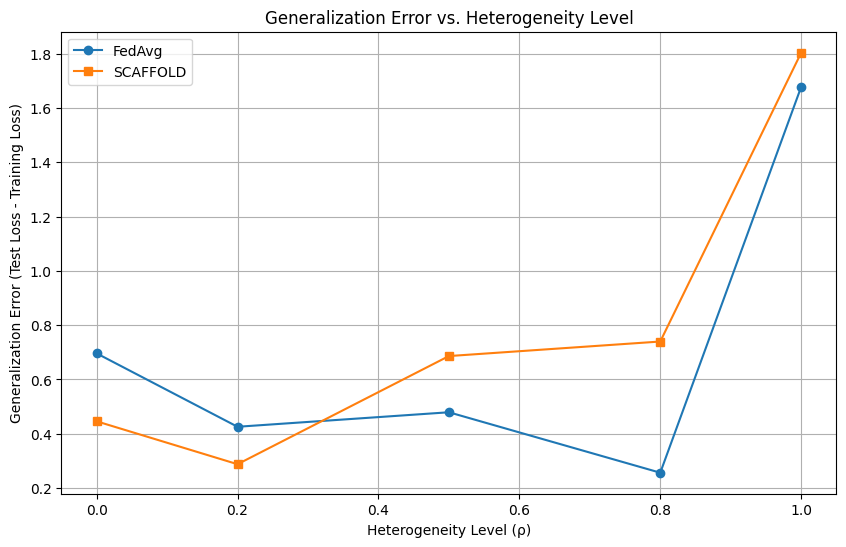

In [ ]:
import matplotlib.pyplot as plt

num_clients = 10
heterogeneity_levels = [0, 0.2, 0.5, 0.8, 1]
epochs = 5
lr = 0.01
rounds = 5
generalization_errors = {'FedAvg': [], 'SCAFFOLD': []}

for rho in heterogeneity_levels:
    print(f"Running experiment for heterogeneity level: {rho}")

    client_datasets = create_datasets(rho, num_clients)
    data_loaders = [DataLoader(dataset, batch_size=32, shuffle=True) for dataset in client_datasets]
    test_loader = DataLoader(datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor()), batch_size=32, shuffle=False)

    # Initialize the global models
    global_model_fedavg = SimpleCNN()
    global_model_scaffold = SimpleCNN()

    # Train using FedAvg
    fedavg_model = train_fedavg(global_model_fedavg, data_loaders, test_loader, epochs, lr, rounds)
    train_loss_fedavg = fedavg_model[1]
    _, test_loss_fedavg = evaluate_model(fedavg_model[0], test_loader)
    generalization_errors['FedAvg'].append(test_loss_fedavg - train_loss_fedavg)

    # Train using SCAFFOLD
    scaffold_model = scaffold(global_model_scaffold, data_loaders, test_loader, epochs, lr, rounds)
    train_loss_scaffold = scaffold_model[1]
    _, test_loss_scaffold = evaluate_model(scaffold_model[0], test_loader)
    generalization_errors['SCAFFOLD'].append(test_loss_scaffold - train_loss_scaffold)

# Plotting the generalization errors vs heterogeneity levels
plt.figure(figsize=(10, 6))
plt.plot(heterogeneity_levels, generalization_errors['FedAvg'], label='FedAvg', marker='o')
plt.plot(heterogeneity_levels, generalization_errors['SCAFFOLD'], label='SCAFFOLD', marker='s')
plt.title('Generalization Error vs. Heterogeneity Level')
plt.xlabel('Heterogeneity Level (ρ)')
plt.ylabel('Generalization Error (Test Loss - Training Loss)')
plt.legend()
plt.grid(True)
plt.show()

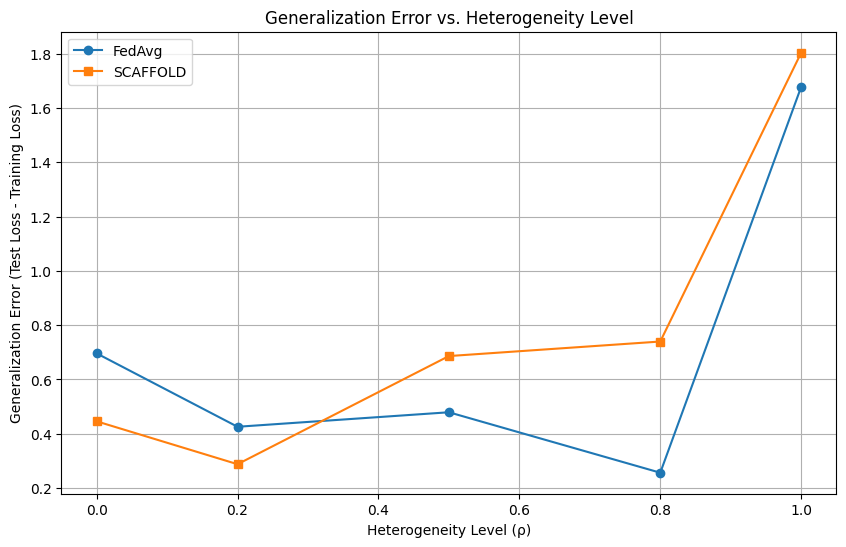

In [ ]:
import math
plt.figure(figsize=(10, 6))
plt.plot(heterogeneity_levels,[abs(err) for err in generalization_errors['FedAvg']], label='FedAvg', marker='o')
plt.plot(heterogeneity_levels, [abs(err) for err in generalization_errors['SCAFFOLD']], label='SCAFFOLD', marker='s')
plt.title('Generalization Error vs. Heterogeneity Level')
plt.xlabel('Heterogeneity Level (ρ)')
plt.ylabel('Generalization Error (Test Loss - Training Loss)')
plt.legend()
plt.grid(True)
plt.show()

Running experiment for heterogeneity level: 0
Round 1/5 - FedProx Accuracy: 58.02%, Loss: 1.4252, Generalization Error: 0.4408
Round 2/5 - FedProx Accuracy: 63.58%, Loss: 1.0959, Generalization Error: 0.4952
Round 3/5 - FedProx Accuracy: 67.53%, Loss: 0.9168, Generalization Error: 0.4690
Round 4/5 - FedProx Accuracy: 72.39%, Loss: 0.7954, Generalization Error: 0.4323
Round 5/5 - FedProx Accuracy: 80.17%, Loss: 0.6842, Generalization Error: 0.3757
Running experiment for heterogeneity level: 0.2
Round 1/5 - FedProx Accuracy: 54.20%, Loss: 1.2789, Generalization Error: 0.2915
Round 2/5 - FedProx Accuracy: 67.04%, Loss: 0.9182, Generalization Error: 0.3165
Round 3/5 - FedProx Accuracy: 69.98%, Loss: 0.7525, Generalization Error: 0.3054
Round 4/5 - FedProx Accuracy: 71.89%, Loss: 0.6646, Generalization Error: 0.3028
Round 5/5 - FedProx Accuracy: 79.47%, Loss: 0.5613, Generalization Error: 0.2545
Running experiment for heterogeneity level: 0.5
Round 1/5 - FedProx Accuracy: 44.16%, Loss: 1.68

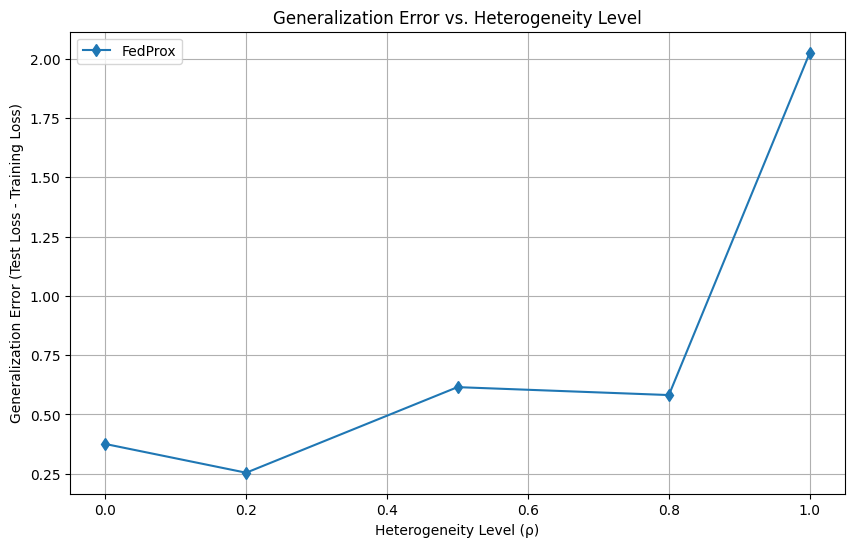

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

# Define the three-layer CNN model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5)
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.max_pool2d(x, 2)
        x = torch.relu(self.conv2(x))
        x = torch.max_pool2d(x, 2)
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
def train_local_model(model, dataloader, epochs, lr):
    model.to(device)  # Move model to GPU
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr)
    model.train()
    training_loss = 0.0
    num_batches = len(dataloader)

    for epoch in range(epochs):
        epoch_loss = 0.0
        for data, target in dataloader:
            data, target = data.to(device), target.to(device)  # Move data to GPU
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        training_loss += epoch_loss / num_batches

    return model.state_dict(), training_loss / epochs

def evaluate_model(model, test_loader):
    model.to(device)  # Move model to GPU
    model.eval()
    test_loss = 0.0
    correct = 0
    num_batches = len(test_loader)
    criterion = nn.CrossEntropyLoss()

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)  # Move data to GPU
            output = model(data)
            loss = criterion(output, target)
            test_loss += loss.item()
            _, predicted = torch.max(output.data, 1)
            correct += (predicted == target).sum().item()

    accuracy = 100 * correct / len(test_loader.dataset)
    avg_test_loss = test_loss / num_batches
    return accuracy, avg_test_loss


def train_fedprox(global_model, data_loaders, test_loader, epochs, lr, rounds, mu):
    num_clients = len(data_loaders)
    train_losses = []

    for round in range(rounds):
        local_models = []

        # Distribute the global model to all clients and train locally
        for i in range(num_clients):
            local_model = SimpleCNN().to(device)  # Move local model to GPU
            local_model.load_state_dict(global_model.state_dict())
            local_state_dict, train_loss = train_local_model_fedprox(local_model, data_loaders[i], epochs, lr, global_model, mu)
            local_models.append(local_state_dict)
            train_losses.append(train_loss)

        # Aggregate local models
        global_state_dict = global_model.state_dict()
        for key in global_state_dict.keys():
            global_state_dict[key] = torch.zeros_like(global_state_dict[key]).to(device)  # Ensure tensor is on the correct device

            for local_model in local_models:
                global_state_dict[key] += local_model[key].to(device)

            global_state_dict[key] /= num_clients

        global_model.load_state_dict(global_state_dict)

        # Evaluate the global model on the test set
        accuracy, test_loss = evaluate_model(global_model, test_loader)
        avg_train_loss = sum(train_losses) / len(train_losses)
        generalization_error = test_loss - avg_train_loss
        print(f"Round {round + 1}/{rounds} - FedProx Accuracy: {accuracy:.2f}%, Loss: {test_loss:.4f}, Generalization Error: {generalization_error:.4f}")

    return global_model, avg_train_loss

def create_datasets(heterogeneity_level, num_clients=10):
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
    full_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

    client_datasets = []
    labels = np.array(full_dataset.targets)
    indices = np.arange(len(full_dataset))

    # Determine the number of IID and non-IID samples per client
    total_samples = len(full_dataset) // num_clients
    non_iid_samples = int(heterogeneity_level * total_samples)
    iid_samples = total_samples - non_iid_samples

    for i in range(num_clients):
        # Create non-IID data for the client
        chosen_labels = np.random.choice(10, 2, replace=False)
        non_iid_indices = np.where((labels == chosen_labels[0]) | (labels == chosen_labels[1]))[0]
        non_iid_indices = np.random.choice(non_iid_indices, non_iid_samples, replace=False)

        # Create IID data for the client
        remaining_indices = np.setdiff1d(indices, non_iid_indices)
        iid_indices = np.random.choice(remaining_indices, iid_samples, replace=False)

        # Combine IID and non-IID data
        client_indices = np.concatenate([non_iid_indices, iid_indices])
        client_datasets.append(Subset(full_dataset, client_indices))

    return client_datasets

num_clients = 10
heterogeneity_levels = [0, 0.2, 0.5, 0.8, 1]
epochs = 5
lr = 0.01
rounds = 5
mu = 0.1  # Proximal term coefficient for FedProx
generalization_errors = {'FedProx': []}

for rho in heterogeneity_levels:
    print(f"Running experiment for heterogeneity level: {rho}")

    client_datasets = create_datasets(rho, num_clients)
    data_loaders = [DataLoader(dataset, batch_size=32, shuffle=True) for dataset in client_datasets]
    test_loader = DataLoader(datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor()), batch_size=32, shuffle=False)

    # Initialize the global models
    global_model_fedprox = SimpleCNN()



    # Train using FedProx
    fedprox_model = train_fedprox(global_model_fedprox, data_loaders, test_loader, epochs, lr, rounds, mu)
    train_loss_fedprox = fedprox_model[1]
    _, test_loss_fedprox = evaluate_model(fedprox_model[0], test_loader)
    generalization_errors['FedProx'].append(test_loss_fedprox - train_loss_fedprox)

# Plotting the generalization errors vs heterogeneity levels
plt.figure(figsize=(10, 6))
plt.plot(heterogeneity_levels, generalization_errors['FedProx'], label='FedProx', marker='d')
plt.title('Generalization Error vs. Heterogeneity Level')
plt.xlabel('Heterogeneity Level (ρ)')
plt.ylabel('Generalization Error (Test Loss - Training Loss)')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

# Define the three-layer CNN model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5)
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.max_pool2d(x, 2)
        x = torch.relu(self.conv2(x))
        x = torch.max_pool2d(x, 2)
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def train_local_model_fedprox(model, dataloader, epochs, lr, global_model, mu):
    model.to(device)  # Move model to GPU
    global_model.to(device)  # Ensure global model is also on GPU
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr)
    model.train()
    training_loss = 0.0
    num_batches = len(dataloader)

    for epoch in range(epochs):
        epoch_loss = 0.0
        for data, target in dataloader:
            data, target = data.to(device), target.to(device)  # Move data to GPU
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)

            # Compute the proximal term
            proximal_term = 0.0
            for param, global_param in zip(model.parameters(), global_model.parameters()):
                proximal_term += torch.norm(param - global_param) ** 2

            # Add proximal term to the loss
            loss += (mu / 2) * proximal_term

            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        training_loss += epoch_loss / num_batches

    return model.state_dict(), training_loss / epochs

def evaluate_model(model, test_loader):
    model.to(device)  # Move model to GPU
    model.eval()
    test_loss = 0.0
    correct = 0
    num_batches = len(test_loader)
    criterion = nn.CrossEntropyLoss()

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)  # Move data to GPU
            output = model(data)
            loss = criterion(output, target)
            test_loss += loss.item()
            _, predicted = torch.max(output.data, 1)
            correct += (predicted == target).sum().item()

    accuracy = 100 * correct / len(test_loader.dataset)
    avg_test_loss = test_loss / num_batches
    return accuracy, avg_test_loss

def train_fedavg(global_model, data_loaders, test_loader, epochs, lr, rounds):
    num_clients = len(data_loaders)
    train_losses = []

    for round in range(rounds):
        local_models = []

        # Distribute the global model to all clients and train locally
        for i in range(num_clients):
            local_model = SimpleCNN().to(device)  # Move local model to GPU
            local_model.load_state_dict(global_model.state_dict())
            local_state_dict, train_loss = train_local_model(local_model, data_loaders[i], epochs, lr)
            local_models.append(local_state_dict)
            train_losses.append(train_loss)

        # Aggregate local models
        global_state_dict = global_model.state_dict()
        for key in global_state_dict.keys():
            global_state_dict[key] = torch.zeros_like(global_state_dict[key]).to(device)  # Ensure tensor is on the correct device

            for local_model in local_models:
                global_state_dict[key] += local_model[key].to(device)

            global_state_dict[key] /= num_clients

        global_model.load_state_dict(global_state_dict)

        # Evaluate the global model on the test set
        accuracy, test_loss = evaluate_model(global_model, test_loader)
        avg_train_loss = sum(train_losses) / len(train_losses)
        generalization_error = test_loss - avg_train_loss
        print(f"Round {round + 1}/{rounds} - FedAvg Accuracy: {accuracy:.2f}%, Loss: {test_loss:.4f}, Generalization Error: {generalization_error:.4f}")

    return global_model, avg_train_loss

def scaffold(global_model, data_loaders, test_loader, epochs, lr, rounds):
    num_clients = len(data_loaders)
    global_control_variates = [torch.zeros_like(param).to(device) for param in global_model.parameters()]

    for round in range(rounds):
        local_models = []
        local_control_variates = []
        train_losses = []

        for i in range(num_clients):
            local_model = SimpleCNN().to(device)
            local_model.load_state_dict(global_model.state_dict())
            local_cv = [torch.zeros_like(param).to(device) for param in local_model.parameters()]

            local_state_dict, train_loss = train_local_model(local_model, data_loaders[i], epochs, lr)
            local_models.append(local_state_dict)
            local_control_variates.append(local_cv)
            train_losses.append(train_loss)

        # Aggregate local models into the global model
        global_state_dict = global_model.state_dict()
        for key in global_state_dict.keys():
            global_state_dict[key] = torch.stack([local_model[key].to(device) for local_model in local_models]).mean(dim=0)

        global_model.load_state_dict(global_state_dict)

        # Update global control variates
        with torch.no_grad():
            for i, (global_cv, param) in enumerate(zip(global_control_variates, global_model.parameters())):
                param = param.to(device)  # Ensure parameter is on the correct device

                if param.grad is None:
                    param.grad = torch.zeros_like(param).to(device)  # Ensure gradient is on the correct device

                update_term = torch.mean(torch.stack([
                    local_cv[i].to(device) + param.grad - global_cv
                    for local_cv in local_control_variates
                ]), dim=0)

                if update_term.shape == global_cv.shape:
                    global_cv += update_term

        # Evaluate the global model on the test set
        accuracy, test_loss = evaluate_model(global_model, test_loader)
        avg_train_loss = sum(train_losses) / len(train_losses)
        generalization_error = test_loss - avg_train_loss
        print(f"Round {round + 1}/{rounds} - SCAFFOLD Accuracy: {accuracy:.2f}%, Loss: {test_loss:.4f}, Generalization Error: {generalization_error:.4f}")

    return global_model, avg_train_loss

def train_fedprox(global_model, data_loaders, test_loader, epochs, lr, rounds, mu):
    num_clients = len(data_loaders)
    train_losses = []

    for round in range(rounds):
        local_models = []

        # Distribute the global model to all clients and train locally
        for i in range(num_clients):
            local_model = SimpleCNN().to(device)  # Move local model to GPU
            local_model.load_state_dict(global_model.state_dict())
            local_state_dict, train_loss = train_local_model_fedprox(local_model, data_loaders[i], epochs, lr, global_model, mu)
            local_models.append(local_state_dict)
            train_losses.append(train_loss)

        # Aggregate local models
        global_state_dict = global_model.state_dict()
        for key in global_state_dict.keys():
            global_state_dict[key] = torch.zeros_like(global_state_dict[key]).to(device)  # Ensure tensor is on the correct device

            for local_model in local_models:
                global_state_dict[key] += local_model[key].to(device)

            global_state_dict[key] /= num_clients

        global_model.load_state_dict(global_state_dict)

        # Evaluate the global model on the test set
        accuracy, test_loss = evaluate_model(global_model, test_loader)
        avg_train_loss = sum(train_losses) / len(train_losses)
        generalization_error = test_loss - avg_train_loss
        print(f"Round {round + 1}/{rounds} - FedProx Accuracy: {accuracy:.2f}%, Loss: {test_loss:.4f}, Generalization Error: {generalization_error:.4f}")

    return global_model, avg_train_loss

def create_datasets(heterogeneity_level, num_clients=10):
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
    full_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

    client_datasets = []
    labels = np.array(full_dataset.targets)
    indices = np.arange(len(full_dataset))

    # Determine the number of IID and non-IID samples per client
    total_samples = len(full_dataset) // num_clients
    non_iid_samples = int(heterogeneity_level * total_samples)
    iid_samples = total_samples - non_iid_samples

    for i in range(num_clients):
        # Create non-IID data for the client
        chosen_labels = np.random.choice(10, 2, replace=False)
        non_iid_indices = np.where((labels == chosen_labels[0]) | (labels == chosen_labels[1]))[0]
        non_iid_indices = np.random.choice(non_iid_indices, non_iid_samples, replace=False)

        # Create IID data for the client
        remaining_indices = np.setdiff1d(indices, non_iid_indices)
        iid_indices = np.random.choice(remaining_indices, iid_samples, replace=False)

        # Combine IID and non-IID data
        client_indices = np.concatenate([non_iid_indices, iid_indices])
        client_datasets.append(Subset(full_dataset, client_indices))

    return client_datasets



Running experiment for heterogeneity level: 0
Round 1/5 - SCAFFOLD Accuracy: 52.58%, Loss: 1.4234, Generalization Error: 0.7255
Round 2/5 - SCAFFOLD Accuracy: 65.05%, Loss: 1.0478, Generalization Error: 0.8952
Round 3/5 - SCAFFOLD Accuracy: 66.21%, Loss: 0.9130, Generalization Error: 0.8148
Round 4/5 - SCAFFOLD Accuracy: 70.29%, Loss: 0.8015, Generalization Error: 0.7274
Round 5/5 - SCAFFOLD Accuracy: 69.92%, Loss: 0.7587, Generalization Error: 0.6987
Round 1/5 - FedProx Accuracy: 58.84%, Loss: 1.2099, Generalization Error: 0.2033
Round 2/5 - FedProx Accuracy: 65.04%, Loss: 0.9026, Generalization Error: 0.2853
Round 3/5 - FedProx Accuracy: 65.75%, Loss: 0.8109, Generalization Error: 0.3505
Round 4/5 - FedProx Accuracy: 73.81%, Loss: 0.6689, Generalization Error: 0.2958
Round 5/5 - FedProx Accuracy: 74.09%, Loss: 0.6418, Generalization Error: 0.3254
Round 1/5 - FedAvg Accuracy: 49.65%, Loss: 1.3547, Generalization Error: 0.6150
Round 2/5 - FedAvg Accuracy: 58.57%, Loss: 0.9906, Generali

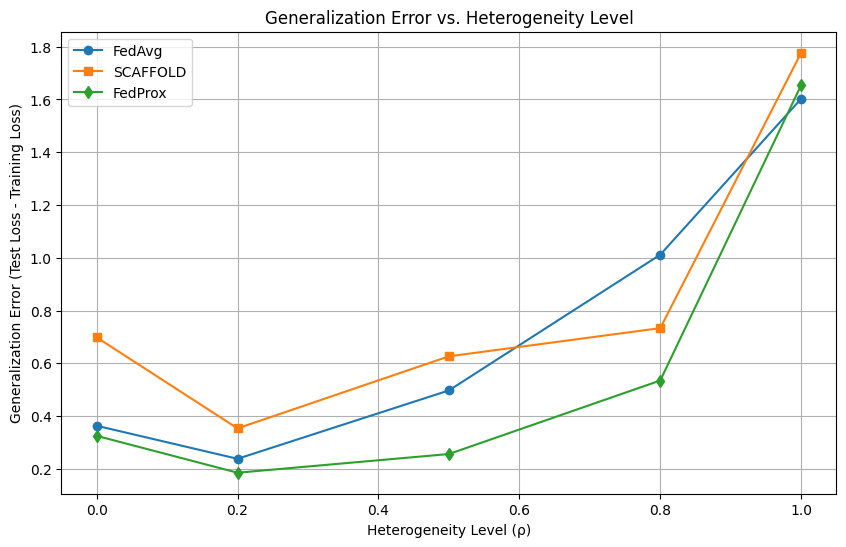

In [ ]:
num_clients = 10
heterogeneity_levels = [0, 0.2, 0.5, 0.8, 1]
epochs = 5
lr = 0.01
rounds = 5
mu = 0.1  # Proximal term coefficient for FedProx
generalization_errors = {'FedAvg': [], 'SCAFFOLD': [], 'FedProx': []}

for rho in heterogeneity_levels:
    print(f"Running experiment for heterogeneity level: {rho}")

    client_datasets = create_datasets(rho, num_clients)
    data_loaders = [DataLoader(dataset, batch_size=32, shuffle=True) for dataset in client_datasets]
    test_loader = DataLoader(datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor()), batch_size=32, shuffle=False)

    # Initialize the global models
    global_model_fedavg = SimpleCNN()
    global_model_scaffold = SimpleCNN()
    global_model_fedprox = SimpleCNN()

    # Train using SCAFFOLD
    scaffold_model = scaffold(global_model_scaffold, data_loaders, test_loader, epochs, lr, rounds)
    train_loss_scaffold = scaffold_model[1]
    _, test_loss_scaffold = evaluate_model(scaffold_model[0], test_loader)
    generalization_errors['SCAFFOLD'].append(test_loss_scaffold - train_loss_scaffold)

    # Train using FedProx
    fedprox_model = train_fedprox(global_model_fedprox, data_loaders, test_loader, epochs, lr, rounds, mu)
    train_loss_fedprox = fedprox_model[1]
    _, test_loss_fedprox = evaluate_model(fedprox_model[0], test_loader)
    generalization_errors['FedProx'].append(test_loss_fedprox - train_loss_fedprox)


    # Train using FedAvg
    fedavg_model = train_fedavg(global_model_fedavg, data_loaders, test_loader, epochs, lr, rounds)
    train_loss_fedavg = fedavg_model[1]
    _, test_loss_fedavg = evaluate_model(fedavg_model[0], test_loader)
    generalization_errors['FedAvg'].append(test_loss_fedavg - train_loss_fedavg)



# Plotting the generalization errors vs heterogeneity levels
plt.figure(figsize=(10, 6))
plt.plot(heterogeneity_levels, generalization_errors['FedAvg'], label='FedAvg', marker='o')
plt.plot(heterogeneity_levels, generalization_errors['SCAFFOLD'], label='SCAFFOLD', marker='s')
plt.plot(heterogeneity_levels, generalization_errors['FedProx'], label='FedProx', marker='d')
plt.title('Generalization Error vs. Heterogeneity Level')
plt.xlabel('Heterogeneity Level (ρ)')
plt.ylabel('Generalization Error (Test Loss - Training Loss)')
plt.legend()
plt.grid(True)
plt.show()